# Goal:
Make a function that returns the ingredients which are a common combination with the entered ingredient

In [2]:
import pandas as pd #Data manipulation
import numpy as np #Array and Matrix operations
import matplotlib.pyplot as plt #Plotting
import seaborn as sb #Plotting
sb.set()

# Dataset Preparation
The following steps are taken to prepare the data for EDA as well as model training:
1. The `id` column is set as the index
2. The Dataframe is sorted based on the `id` column
3. We convert all ingredients to lowercase

In [3]:
#DataFrame manipulation
data = pd.read_json("data/train.json")
data = data.set_index("id") 
data = data.sort_values("id")
data.ingredients = data.ingredients.apply(lambda ings : [ing.lower() for ing in ings]) #Lower case all ingredients
data.head()

,cuisine,ingredients
id,,
0,spanish,"[mussels, ground black pepper, garlic cloves, ..."
1,mexican,"[tomatoes, diced red onions, paprika, salt, co..."
2,french,"[chicken broth, truffles, pimentos, green pepp..."
3,chinese,"[fresh ginger, sesame oil, frozen peas, cooked..."
4,italian,"[orange peel, cookies, vanilla ice cream, gran..."


# Ingredient Co-occurrence
The simplest method to recommend ingredients is to see which 2 inredients occur the most together.
We use `itertools.combinations` which goes through an array and makes a combination of 2 ingredients for the entire array

In [4]:
#Calculating ingredient co-occurrences
import itertools
from collections import Counter
cooc_counts = Counter()
ing_count = Counter()

for ingredients in data.ingredients:
    for ing in ingredients:
        ing_count[ing] += 1
    for(ing_a, ing_b) in itertools.combinations(set(ingredients), 2):
        #We want the pairs of ingredients in a consistent order(alphabetically)
        if(ing_a > ing_b):
            ing_a, ing_b = ing_b, ing_a
        cooc_counts[(ing_a, ing_b)] += 1

In [5]:
cooc_df = pd.DataFrame(((ing_a, ing_b, ing_count[ing_a], ing_count[ing_b], cooc) for (ing_a, ing_b), cooc in cooc_counts.items()), columns=['a', 'b', 'a_count', 'b_count', 'cooc'])
cooc_df.sample(10)

,a,b,a_count,b_count,cooc
143748,couscous,crushed red pepper,189,825,7
129089,ground nutmeg,large garlic cloves,605,873,14
340683,ground pork,sausages,473,185,2
458549,celery,feta cheese crumbles,837,358,1
288210,cotija,hass avocado,139,43,1
477205,pork bouillon cube,pork shoulder,3,135,1
253702,cracked black pepper,duck,408,49,2
31635,cooked rice,garlic chili sauce,387,130,4
200562,mushrooms,sliced black olives,578,161,4
218906,fresh dill,horseradish,243,45,3


In [6]:
#Find ingredients most common with Condensed Milk
cooc_df[cooc_df.a == 'condensed milk'].sort_values('cooc', ascending=False).head(10)

,a,b,a_count,b_count,cooc
40197,condensed milk,sugar,74,6434,33
84291,condensed milk,water,74,7457,25
40200,condensed milk,eggs,74,3388,19
71303,condensed milk,vanilla extract,74,1298,16
71301,condensed milk,egg yolks,74,542,13
40202,condensed milk,evaporated milk,74,208,13
47904,condensed milk,milk,74,2263,13
166595,condensed milk,whole milk,74,764,9
86943,condensed milk,salt,74,18049,9
79010,condensed milk,unsalted butter,74,2782,7


As we can see, the most common ingredients are not those which would be common in a recipe with the input ingredient, but are ingredients which are common as a whole in the entire dataset. E.g. Sugar, water, etc.  
___

The clear problem is that co-occurrences are skewed by ingredient frequency in the dataset as mentioned above.

To solve this problem we use something known as ***Pointwise Mutual Information(PMI)*** :
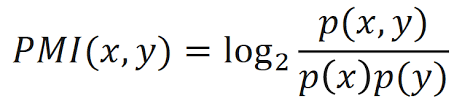

**P(X) = Counts(X)/(Total Recipes in Dataset)**  
**P(Y) = Counts(Y)/(Total Recipes in Dataset)**  
**P(X, Y) = Co-occurrence(X, Y)/(Sum of Total Co-occurrences in Dataset)**

The numerator in the formula signifies the **Probability of 2 ingredients occurring together**  
The denominator in the formula signifies the **Probability of 2 ingredients occurring separately**

Therefore, this formula also takes into account the fact that ingredients may be more common but may not occur together.

In [7]:
p_a = cooc_df.a_count / sum(ing_count.values())
p_b = cooc_df.b_count / len(ing_count.values())
p_a_b = cooc_df.cooc / cooc_df.cooc.sum()
cooc_df['pmi'] = np.log(p_a_b / (p_a * p_b))

In [8]:
cooc_df.sort_values('pmi', ascending=False).head(10)

,a,b,a_count,b_count,cooc,pmi
266285,light cream or half and half,lipton green tea bag,1,1,1,7.053491
267740,frozen basil,red wine vinaigrette,1,1,1,7.053491
451674,mazolaâ® chicken flavor bouillon powder,spice islands bay leaves,1,1,1,7.053491
201712,miswa,pork heart,1,1,1,7.053491
443901,chipped beef,chourico,1,1,1,7.053491
267633,mccormick taco seasoning,tomato sauce low sodium,1,1,1,7.053491
203479,gluten free barbecue sauce,rub seasoning,1,1,1,7.053491
461099,chuck short ribs,prune juice,1,1,1,7.053491
478965,hawaiian salt,raw buckwheat groats,1,1,1,7.053491
478958,raw buckwheat groats,sliced mango,1,1,1,7.053491


We see ingredients which have a very low occurrence in the overall dataset and can be removed  
`Note:` This also shows that instead of just using ingredients as a single entity, we should treat them like n-grams (Olive Oil and Virgin Olive Oil should be treated similarly)

In [9]:
min_count = 5
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count)].sort_values('pmi', ascending=False).head(20)

,a,b,a_count,b_count,cooc,pmi
155708,herdez salsa casera,herdez salsa verde,5,6,3,4.750905
176276,black treacle,porridge oats,7,5,3,4.596755
194561,kewra water,stone flower,6,6,3,4.568584
332632,sazon seasoning,sofrito,5,5,2,4.527762
34074,mo hanh,vegan mayonnaise,5,6,2,4.345440
275438,chinese rose wine,maltose,5,9,3,4.345440
54542,rye whiskey,twists,6,5,2,4.345440
194372,johnsonville andouille,red goldâ® diced tomatoes,6,5,2,4.345440
313702,black rice vinegar,chinese sesame paste,9,5,3,4.345440
438236,bertolli vineyard premium collect marinara wit...,"clams, well scrub",5,6,2,4.345440


Using a minimum criteria of 5 occurrences shows that some ingredients have the brand names mentioned in them (E.g. Herdez Salsa Casera, Shahi Jeera, etc.). The brand names have nothing to do with cuisine and just increase unique ingredient count.

In [10]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count)].sort_values('pmi', ascending=False).head(20)

,a,b,a_count,b_count,cooc,pmi
54954,brown cardamom,green cardamom,40,86,27,2.206101
31796,gari,wasabi,50,32,12,2.160638
104752,dried bonito flakes,konbu,42,66,18,2.016538
60445,bonito flakes,konbu,38,66,16,1.998838
26577,asafoetida powder,fresh curry leaves,33,69,13,1.887826
31798,sushi rice,wasabi,81,32,14,1.832363
36983,coffee granules,coffee liqueur,34,30,5,1.735371
13276,condensed cream of chicken soup,condensed cream of mushroom soup,62,55,16,1.691612
57164,brown cardamom,mace,40,81,15,1.678212
26576,asafoetida powder,dried red chile peppers,33,103,15,1.630304


Using a minimum criteria of 30 occurrences begins to show real relationships

In [11]:
min_count = 30
cooc_df[(cooc_df.a_count >= min_count) & (cooc_df.b_count >= min_count) & (cooc_df.cooc > 1)].sort_values('pmi', ascending=True).head(20)

,a,b,a_count,b_count,cooc,pmi
217477,pepper,vanilla extract,4438,1298,2,-7.819901
16582,sesame oil,unsalted butter,1773,2782,2,-7.664716
257328,garlic,powdered sugar,7380,501,2,-7.376497
255710,cooking spray,soy sauce,1490,3296,3,-7.254893
246191,garlic,large garlic cloves,7380,873,4,-7.238680
259891,diced tomatoes,sesame oil,1624,1773,2,-7.126438
167121,buttermilk,soy sauce,863,3296,2,-7.114242
131069,grated parmesan cheese,soy sauce,1886,3296,5,-6.979750
414690,confectioners sugar,garlic cloves,395,6237,2,-6.970503
419442,extra-virgin olive oil,vanilla extract,2747,1298,3,-6.934742


If we ignore those ingredient pairs with just 1 co-occurrence and negative PMI, we see ingredients which don't have any co-occurrence (E.g. Soy Sauce and Whipping Cream).

This is because in the PMI, their denominator was greater than the numerator, making the log negative.  
___

# Matrix Factorisation
We are currently only using direct correlations between 2 ingredients. For example, there are 10 recipes in which `Spaghetti` and `Oregano` appear together. This means we are ignoring more subtle relations. `Parmesan` might not be in many recipes with `Spaghetti` but it could be in many recipes which are closely related to `Spaghetti` as well.

To fix this sparseness situation (where most ingredient pairs have around no correlation ), we use a technique called matric factorisation:
1. Make a matrix where Rows and Columns are all the ingredients and the intersecting values are the PMI values
2. We factorize the matrix - split an NxN matrix into smaller NxK and KxN matrices where K<N (We take K = 120 since it gives good results)

Matrix factorisation removes noisy data and generalises the knowledge to all ingredients. The output is a vector for each ingredient which we can compare with vectors of other ingredients. 

In [12]:
#Using matrix factorization
from scipy.sparse import csr_matrix
data_df = cooc_df[cooc_df.pmi > 0].copy()
# Since the matrix is symetric, we add the same values for (b,a) as we have for (a,b)
data_df_t = data_df.copy()
data_df.a, data_df.b = data_df.b, data_df.a
data_df = pd.concat([data_df, data_df_t])

rows_idx, row_keys = pd.factorize(data_df.a)
cols_idx, col_keys = pd.factorize(data_df.b)
values = data_df.pmi

matrix = csr_matrix((values, (rows_idx, cols_idx)))
key_to_row = {key: idx for idx, key in enumerate(row_keys)}

In [13]:
from sklearn.decomposition import TruncatedSVD

#Using Singular Value Decomposition to reduce dimensionality
svd = TruncatedSVD(200)
factors = svd.fit_transform(matrix)

In [75]:
from sklearn.metrics.pairwise import cosine_similarity
def most_similar(ingredient, topn=10):
    if ingredient not in key_to_row:
        print("Unknown ingredient.")
    factor = factors[key_to_row[ingredient]]
    cosines = cosine_similarity([factor], factors)[0]
    indices = cosines.argsort()[::-1][:topn + 1]
    keys = [row_keys[idx] for idx in indices if idx != key_to_row[ingredient]]
    return keys, cosines[indices]

def display_most_similar(ingredient, topn=10):
    print("- Most similar to '{}'".format(ingredient))
    similar_ings = []
    ing_scores = []
    for similar_ing, score in zip(*most_similar(ingredient, topn)):
        print("  . {} : {:.2f}".format(similar_ing, score)) 
        similar_ings.append(similar_ing)
        ing_scores.append(score)
    return similar_ings, ing_scores

In [76]:
result_ings, ing_scores = display_most_similar('beans', 20)

- Most similar to 'beans'
  . chihuahua cheese : 1.00
  . feta cheese crumbles : 0.54
  . red wine vinaigrette : 0.54
  . frozen basil : 0.53
  . whole wheat penne : 0.52
  . merguez sausage : 0.49
  . roasted tomatoes : 0.49
  . cornbread mix : 0.49
  . full fat sour cream : 0.49
  . chipotle : 0.49
  . gluten free cooking spray : 0.49
  . baby broccoli : 0.49
  . hurst family harvest chipotle lime black bean soup mix : 0.48
  . chili seasoning : 0.48
  . kraft sharp cheddar cheese : 0.48
  . crystal farms reduced fat shredded marble jack cheese : 0.48
  . gluten free corn tortillas : 0.48
  . cottage cheese : 0.47
  . cooked beetroot : 0.47
  . ground turkey : 0.46


In [78]:
print(result_ings)

['chihuahua cheese', 'feta cheese crumbles', 'red wine vinaigrette', 'frozen basil', 'whole wheat penne', 'merguez sausage', 'roasted tomatoes', 'cornbread mix', 'full fat sour cream', 'chipotle', 'gluten free cooking spray', 'baby broccoli', 'hurst family harvest chipotle lime black bean soup mix', 'chili seasoning', 'kraft sharp cheddar cheese', 'crystal farms reduced fat shredded marble jack cheese', 'gluten free corn tortillas', 'cottage cheese', 'cooked beetroot', 'ground turkey']


In [79]:
print(ing_scores)

[1.0000000000000002, 0.5411098488268857, 0.535595071088597, 0.5267506304520572, 0.5238135162994568, 0.4938271215683919, 0.4902801484889101, 0.4885695704273072, 0.48822965730992784, 0.48714193849512993, 0.48669103668154595, 0.4852825331626499, 0.4836735331979542, 0.48305999007772094, 0.4798872934982517, 0.47541987779693806, 0.47517591656374375, 0.471628712133975, 0.46937381134252404, 0.461151882500636]


# Exporting models to run on Flask
To run this model on Flask, we will need to export `key_to_row`, `row_keys` and `factors`

In [82]:
from sklearn.externals import joblib
joblib.dump(key_to_row, 'ingredient_key_to_row.pkl', compress=9)
joblib.dump(factors, 'ingredient_factors.pkl', compress=9)
joblib.dump(row_keys, 'ingredient_row_.pkl', compress=9)

['ingredient_factors.pkl']